# Введение

В данном ноутбуке содержится мое решение задачи, предложенной [здесь](https://github.com/machine-intelligence-laboratory/InternshipTestTask/tree/master/cigarette_butt_segmentation).

Задача заключается в бинарной семантической сегментации изображений.  

Нужно построить модель, сегментирующую окурки сигарет на фотографии.  
  
Метрика, по которой оценивается качество модели, -- [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  
  
Используемый датасет доступен по [ссылке](https://www.immersivelimit.com/datasets/cigarette-butts). 

Доступные данные -- фотографии 512x512x3.

Общее число тренировочных фотографий -- 2000, валидационных -- 200, тестовых -- 10.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# os.chdir('..')
os.chdir('./drive/MyDrive/Cigarette_segmentation')
os.listdir('.')

['notebooks', 'results', 'lib', 'cig_butts.zip', 'data']

In [ ]:
# ! wget https://raw.githubusercontent.com/machine-intelligence-laboratory/InternshipTestTask/master/cigarette_butt_segmentation/lib/__init__.py -O ./lib/__init__.py
# ! wget https://raw.githubusercontent.com/machine-intelligence-laboratory/InternshipTestTask/master/cigarette_butt_segmentation/lib/html.py -O ./lib/html.py
# ! wget https://raw.githubusercontent.com/machine-intelligence-laboratory/InternshipTestTask/master/cigarette_butt_segmentation/lib/metrics.py -O ./lib/metrics.py
# ! wget https://raw.githubusercontent.com/machine-intelligence-laboratory/InternshipTestTask/master/cigarette_butt_segmentation/lib/show.py -O ./lib/show.py
# ! wget https://raw.githubusercontent.com/machine-intelligence-laboratory/InternshipTestTask/master/cigarette_butt_segmentation/lib/utils.py -O ./lib/utils.py

In [ ]:
# !unzip './cig_butts.zip' -d '.'

# os.rename('cig_butts', 'data')

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize

from glob import glob

from lib import *

%matplotlib inline
np.set_printoptions(precision=4)

---

## Данные, метрика и доступные функции

Посмотрим на данные

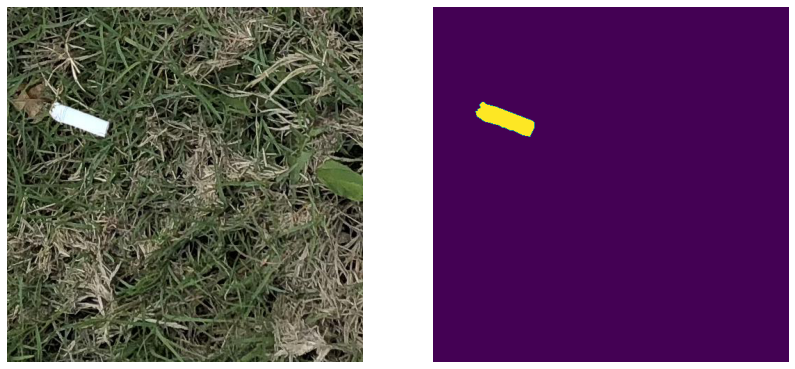

In [ ]:
path = "./data/train"
images = os.listdir(f"{path}/images")
annotations = json.load(open(f"{path}/coco_annotations.json", "r"))
img_id = int(images[28].split(".")[0])

img = np.array(Image.open(f"{path}/images/{img_id:08}.jpg").convert('RGB'))
mask = get_mask(img_id, annotations)
show_img_with_mask(img, mask)

Пример подсчета метрики

In [ ]:
random_mask = np.random.randint(low=0, high=2, size=mask.shape)
get_dice(mask, random_mask)

0.014638003087233151

Можно для последовательности масок вычислить среднее значение метрики

In [ ]:
random_masks_1 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
random_masks_2 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
get_dice(random_masks_1, random_masks_2)

0.5007439790076427

# Перейдем к решению задачи

### Dataset and dataloader

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, path, folder):
      self.path = path
      self.folder = folder
      self.extension = '.jpg'

      if self.folder == 'val':
          self.extension = '.png'
      

      img_names = os.listdir(f"{path}/images")
      img_names = img_names[:2000]
      annotations = json.load(open(f"{path}/coco_annotations.json", "r"))

      self.names = img_names
      self.annotations = annotations

  def __len__(self):
      return len(self.names)

  def load_image(self, idx):
      
      #  load  image  
      img_id = int(self.names[idx].split(".")[0])
      img = np.array(Image.open(f"{self.path}/images/{img_id:08}" + self.extension).convert('RGB'))
      mask = get_mask(img_id, self.annotations)   
      return img, mask
  
  def preprocess_image(self, img, mask):
      #  preprocess  image
      img_tensor = ToTensor()(img)
      img_final = Resize((256, 256))(img_tensor)
      mask_tensor = ToTensor()(mask)
      mask_final = Resize((256, 256))(mask_tensor)
      return img_final, mask_final
    
  def __getitem__(self, idx):
     
      img, mask = self.load_image(idx)

      return self.preprocess_image(img, mask)

In [ ]:
train_data = ImageDataset(path = './data/train', folder = 'train')
valid_data = ImageDataset(path = './data/val', folder = 'val')
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=1, shuffle=True)

torch.Size([3, 256, 256])
tensor(1.)
torch.float32


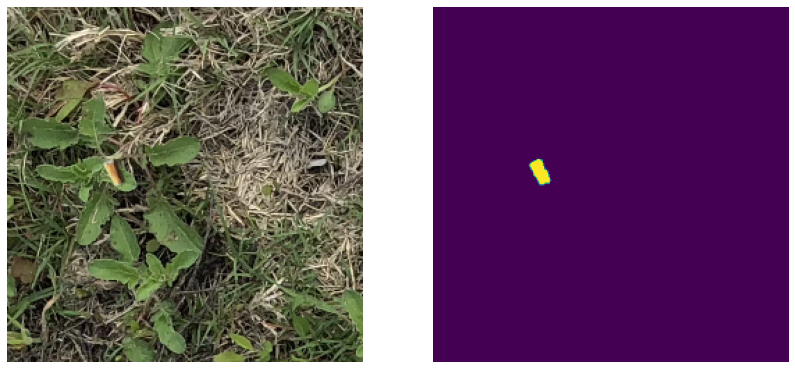

In [ ]:
img, mask = valid_data[8]
print(img.shape)
print(torch.max(mask))
print(mask.dtype)

img_numpy = img.permute(1, 2, 0).numpy()        # permute(1, 2, 0)

mask_numpy = mask.permute(1, 2, 0).squeeze(2).numpy()         #  permute(1, 2, 0).squeeze(2)

show_img_with_mask(img_numpy, mask_numpy)

### Model

Используемая мной модель -- unet. Имплементация unet для pytorch взята по [ссылке](https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201).



In [ ]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

In [ ]:
# inputs = torch.randn((2, 3, 512, 512))
# model = build_unet()
# y = model(inputs)
# print(y.shape)

### Train

In [ ]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

print(device)

unet_model = build_unet()
unet_model = unet_model.to(device)

cuda:0


In [ ]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

Training loop

In [ ]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
      model.train()
      batch_losses=[]
      if change_lr:
          optimizer = change_lr(optimizer, epoch)
      for i, data in enumerate(tqdm(train_loader)):
          img, mask = data
          optimizer.zero_grad()
          img = img.to(device, dtype=torch.float32)
          mask = mask.to(device, dtype=torch.float32)
          pred_mask = model(img)
          loss = loss_fn(pred_mask, mask)
          loss.backward()
          batch_losses.append(loss.item())
          optimizer.step()
      train_losses.append(batch_losses)
      print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
      model.eval()
      batch_losses=[]
      trace_y = []
      trace_yhat = []
      for i, data in enumerate(valid_loader):
          img, mask = data
          img = img.to(device, dtype=torch.float32)
          mask = mask.to(device, dtype=torch.float32)
          pred_mask = model(img)
          loss = loss_fn(pred_mask, mask)
          trace_y.append(mask.permute(2, 3, 1, 0).squeeze(3).squeeze(2).cpu().detach().numpy())      
          pred_mask_final = torch.heaviside(input = pred_mask, values = torch.tensor([0.0]).to(device, dtype=torch.float32))          
          trace_yhat.append(pred_mask_final.permute(2, 3, 1, 0).squeeze(3).squeeze(2).cpu().detach().numpy())      
          batch_losses.append(loss.item())
      valid_losses.append(batch_losses)
      # print(trace_y[0].shape)
      
    
      accuracy = get_dice(trace_y, trace_yhat)
      print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Dice : {accuracy}')

In [ ]:
learning_rate = 0.001
optimizer = optim.Adam(unet_model.parameters(), lr=learning_rate)
epochs = 7
loss_fn = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(2.0)) 
unet_train_losses=[]
unet_valid_losses=[]
def lr_decay(optimizer, epoch):
    if (epoch-1)%3==0 and epoch != 1:
        new_lr = learning_rate / (10**((epoch-1)//3))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer
train(unet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, unet_train_losses, unet_valid_losses, lr_decay)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch - 1 Train-Loss : 0.12300738216936588
Epoch - 1 Valid-Loss : 0.04817179335746914 Valid-Dice : 0.48435611119230715


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch - 2 Train-Loss : 0.03455698450654745
Epoch - 2 Valid-Loss : 0.11205377083271742 Valid-Dice : 0.5551421238825651


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch - 3 Train-Loss : 0.025995587207376956
Epoch - 3 Valid-Loss : 0.03734378630993888 Valid-Dice : 0.6645477708381753
Changed learning rate to 0.0001


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch - 4 Train-Loss : 0.018982415698468685
Epoch - 4 Valid-Loss : 0.01884041024139151 Valid-Dice : 0.74415456071707


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch - 5 Train-Loss : 0.016144991405308246
Epoch - 5 Valid-Loss : 0.01720927785616368 Valid-Dice : 0.7389688553196517


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch - 6 Train-Loss : 0.014747918037697674
Epoch - 6 Valid-Loss : 0.014195687172468751 Valid-Dice : 0.7892606561408738
Changed learning rate to 1e-05


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch - 7 Train-Loss : 0.014253254899755121
Epoch - 7 Valid-Loss : 0.013254561736248434 Valid-Dice : 0.8129965834641084


In [ ]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

### Checking model perfomance on valid

In [ ]:
def validate_one_image(model, valid_data, num, loss_fn):
    model.eval()
    
    img, mask = valid_data[num]
    img = img.unsqueeze(0)
    mask = mask.unsqueeze(0)
    img = img.to(device, dtype=torch.float32)
    mask = mask.to(device, dtype=torch.float32)
    pred_mask = model(img)
    loss = loss_fn(pred_mask, mask)
          
    # print('Loss:', loss.item())

    img_numpy = img.permute(2, 3, 1, 0).squeeze(3).cpu().detach().numpy()        
    mask_numpy = mask.permute(2, 3, 1, 0).squeeze(3).squeeze(2).cpu().detach().numpy()    
    pred_mask_final = torch.heaviside(input = pred_mask, values = torch.tensor([0.0]).to(device, dtype=torch.float32)) 
    pred_mask_numpy = pred_mask_final.permute(2, 3, 1, 0).squeeze(3).squeeze(2).cpu().detach().numpy() 

    accuracy = get_dice(pred_mask_numpy, mask_numpy) 
    print('Dice coefficient:', accuracy)

    show_img_with_mask(img_numpy, pred_mask_numpy)

    return pred_mask_numpy

Dice coefficient: 0.9468196037538116


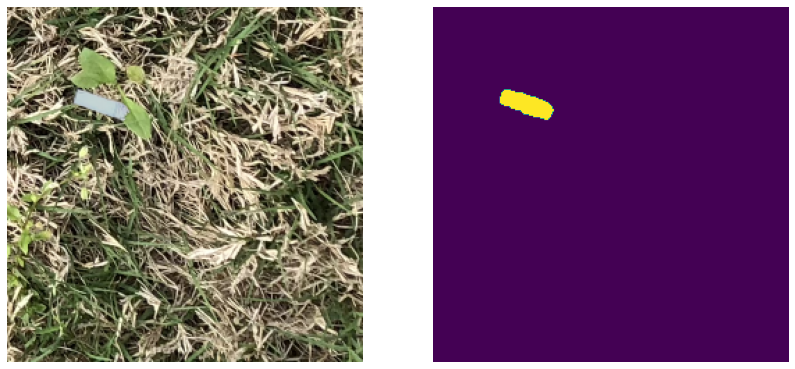

In [ ]:
pred_mask_numpy = validate_one_image(unet_model, valid_data, 7, loss_fn)

# print(pred_mask_numpy.shape)
# print(np.max(pred_mask_numpy))
# print(np.min(pred_mask_numpy))
# print(np.mean(pred_mask_numpy))

In [ ]:
# pred_mask_numpy = validate_one_image(unet_model, valid_data, 3, loss_fn)

### Checking model perfomance on real test

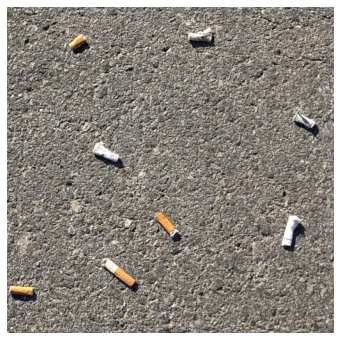

In [ ]:
path = "./data/real_test"
images = sorted(os.listdir(f"{path}"))

img_id = int(images[4].split(".")[0])

img = np.array(Image.open(f"{path}/{img_id:04}.JPG").convert('RGB'))

def show_image(img, figsize = (6, 6)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img)
    ax.axis("off")
    plt.show()

show_image(img)

Dataloader for real test data

In [ ]:
class ImageDataset_Test(Dataset):
  def __init__(self, path):
      self.path = path
      self.extension = '.JPG'

      img_names = sorted(os.listdir(f"{path}"))
      self.names = img_names
      
  def __len__(self):
      return len(self.names)

  def load_image(self, idx):
      #  load  image  
      img_id = int(self.names[idx].split(".")[0])
      img = np.array(Image.open(f"{self.path}/{img_id:04}" + self.extension).convert('RGB'))
      return img
  
  def preprocess_image(self, img):
      #  preprocess  image
      img_tensor = ToTensor()(img)
      img_final = Resize((256, 256))(img_tensor)
      return img_final
    
  def __getitem__(self, idx):
       
      img = self.load_image(idx)

      return self.preprocess_image(img)

In [ ]:
test_data = ImageDataset_Test(path = './data/real_test')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
def test_one_image(model, test_data, num):
    model.eval()
    
    img = test_data[num]
    img = img.unsqueeze(0)
    img = img.to(device, dtype=torch.float32)
    pred_mask = model(img)
          
    img_numpy = img.permute(2, 3, 1, 0).squeeze(3).cpu().detach().numpy()        
    pred_mask_final = torch.heaviside(input = pred_mask, values = torch.tensor([0.0]).to(device, dtype=torch.float32)) 
    pred_mask_final = Resize((512, 512))(pred_mask_final)
    pred_mask_numpy = pred_mask_final.permute(2, 3, 1, 0).squeeze(3).squeeze(2).cpu().detach().numpy() 

    show_img_with_mask(img_numpy, pred_mask_numpy)

    return pred_mask_numpy

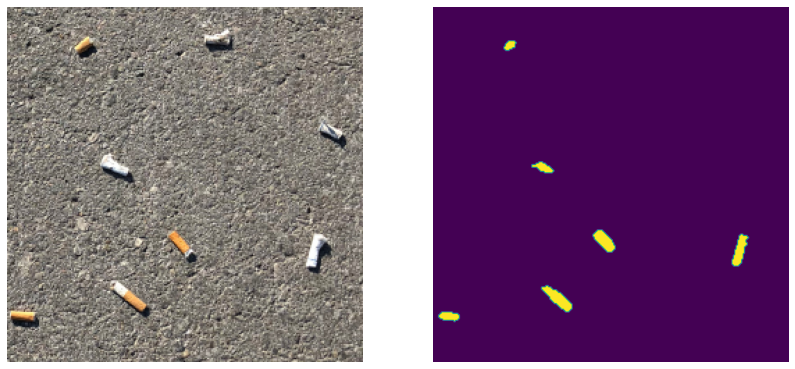

In [ ]:
pred_mask_numpy = test_one_image(unet_model, test_data, 4)

### Save predictions on test data

In [ ]:
def predict(model, dataset):
    mask_list = []
    model.eval()

    for data in dataset:
        img = data
        img = img.unsqueeze(0)
        img = img.to(device, dtype=torch.float32)
        pred_mask = model(img)
              
        pred_mask_final = torch.heaviside(input = pred_mask, values = torch.tensor([0.0]).to(device, dtype=torch.float32)) 
        pred_mask_final = Resize((512, 512))(pred_mask_final)
        pred_mask_numpy = pred_mask_final.permute(2, 3, 1, 0).squeeze(3).squeeze(2).cpu().detach().numpy() 
        mask_list.append(pred_mask_numpy)

    return mask_list

In [ ]:
pred_mask_list = predict(unet_model, test_data)

In [ ]:
pred_masks_final = [np.array(Image.fromarray(255*mask).convert('L')) for mask in pred_mask_list]

In [ ]:
paths_to_imgs = sorted(glob("data/real_test/*"))
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]

_ = get_html(paths_to_imgs, pred_masks_final, path_to_save="results/test_predictions")

### Additional experiment -- training network with dice loss

Ранее мы использовали ```binary cross entropy loss``` для обучения сети. Попробуем использовать непосредственно ```Dice coefficient```, взятый с противоположным знаком, в качестве функции потерь для обучения сети.

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-4):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


In [ ]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

print(device)

dice_unet = build_unet()
dice_unet = dice_unet.to(device)

cuda:0


In [ ]:
learning_rate = 0.0001
optimizer = optim.Adam(dice_unet.parameters(), lr=learning_rate)
epochs = 7
loss_fn = DiceLoss()
unet_train_losses=[]
unet_valid_losses=[]
def lr_decay(optimizer, epoch):
    if (epoch-1)%3==0 and epoch != 1:
        new_lr = learning_rate / (10**((epoch-1)//3))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer
train(dice_unet, loss_fn, train_loader, valid_loader, epochs, optimizer, unet_train_losses, unet_valid_losses, lr_decay)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 0.9332004716396332
Epoch - 1 Valid-Loss : 0.9132267984747887 Valid-Dice : 0.5720093689499958


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch - 2 Train-Loss : 0.8678481001853943
Epoch - 2 Valid-Loss : 0.8315898692607879 Valid-Dice : 0.7413812067917742


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch - 3 Train-Loss : 0.7296636600494385
Epoch - 3 Valid-Loss : 0.7061984285712242 Valid-Dice : 0.6960820087547254
Changed learning rate to 1e-05


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch - 4 Train-Loss : 0.5968732171058655
Epoch - 4 Valid-Loss : 0.6091530123353004 Valid-Dice : 0.8463597208258292


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch - 5 Train-Loss : 0.5669277484416961
Epoch - 5 Valid-Loss : 0.5910101217031479 Valid-Dice : 0.8626649855251763


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch - 6 Train-Loss : 0.5436735816001892
Epoch - 6 Valid-Loss : 0.5695678362250328 Valid-Dice : 0.862825875444897
Changed learning rate to 1e-06


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch - 7 Train-Loss : 0.531604074716568
Epoch - 7 Valid-Loss : 0.5682992321252823 Valid-Dice : 0.8735356745072902


Dice coefficient: 0.7608440797185955


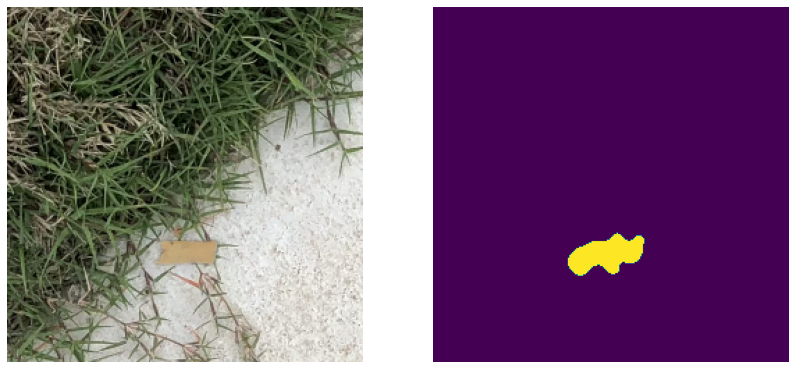

In [ ]:
pred_mask_numpy = validate_one_image(dice_unet, valid_data, 11, loss_fn)

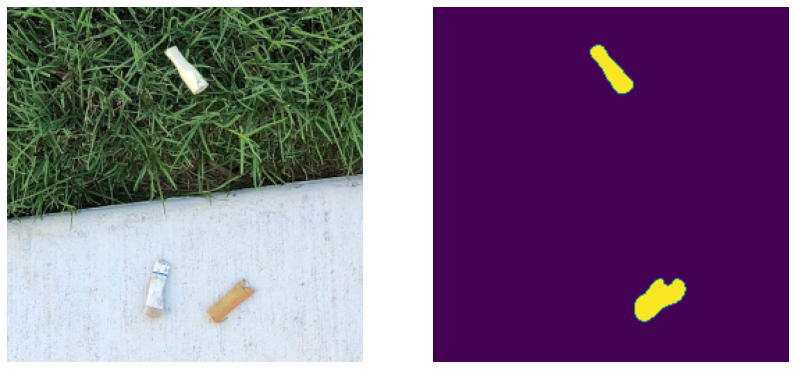

In [ ]:
pred_mask_numpy = test_one_image(dice_unet, test_data, 5)

In [ ]:
pred_mask_list = predict(dice_unet, test_data)
pred_masks_final = [np.array(Image.fromarray(255*mask).convert('L')) for mask in pred_mask_list]

In [ ]:
paths_to_imgs = sorted(glob("data/real_test/*"))
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]

_ = get_html(paths_to_imgs, pred_masks_final, path_to_save="results/dice_test_prediction")

### Итоговые средние значения метрики на валидационном датасете

Вычислим итоговые средние значения метрики (Dice coefficient) на валидационном датасете для двух моделей: сети, которая обучалась с ```BCE loss```, и сети, которая обучалась с ```Dice loss```.

In [ ]:
def metric_on_val(model, loader):    
    model.eval()
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(tqdm(loader)): 
        img, mask = data
        img = img.to(device, dtype=torch.float32)
        mask = mask.to(device, dtype=torch.float32)
        pred_mask = model(img)
        
        mask_numpy_batch = mask.permute(2, 3, 1, 0).squeeze(2).cpu().detach().numpy()
        for i in range(mask_numpy_batch.shape[2]):
            trace_y.append(mask_numpy_batch[:, :, i])   

        pred_mask_final = torch.heaviside(input = pred_mask, values = torch.tensor([0.0]).to(device, dtype=torch.float32))
        pred_mask_numpy_batch = pred_mask_final.permute(2, 3, 1, 0).squeeze(2).cpu().detach().numpy()
        for i in range(pred_mask_numpy_batch.shape[2]):
            trace_yhat.append(pred_mask_numpy_batch[:, :, i])      
        
    accuracy = get_dice(trace_y, trace_yhat)
    # print(f'Average Dice coefficient : {accuracy}')
    return accuracy

In [ ]:
final_metric_unet_model = metric_on_val(unet_model, valid_loader)
final_metric_dice_model = metric_on_val(dice_unet, valid_loader)

print('Average metric on val of unet_model', final_metric_unet_model)
print('Average metric on val of dice_model', final_metric_dice_model)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Average metric on val of unet_model 0.8129965834641082
Average metric on val of dice_model 0.8735356745072902


Ради интереса посмотрим средние значения метрики на тренировочном датасете.

In [ ]:
train_metric_unet_model = metric_on_val(unet_model, train_loader)
train_metric_dice_model = metric_on_val(dice_unet, train_loader)

print('Average metric on train of unet_model', train_metric_unet_model)
print('Average metric on train of dice_model', train_metric_dice_model)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Average metric on train of unet_model 0.8049142151775702
Average metric on train of dice_model 0.8664611587776925


Видно, что средние значения метрики качества для обоих моделей примерно одинаковые.

# Результаты

В папках ```results/test_predictions```, ```results/dice_test_predictions``` загружены предсказания обоих моделей для тестовых данных.

Создадим теперь pdf-файл с тестовыми изображениями и предсказаниями масок для обоих моделей.

In [ ]:
# pip install fpdf

  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40722 sha256=cd80e3d184a52e7ec60bbfb79d4366a1ffc4e2d63993273f513c7f382352225f
  Stored in directory: /root/.cache/pip/wheels/d7/ca/c8/86467e7957bbbcbdf4cf4870fc7dc95e9a16404b2e3c3a98c3
Successfully built fpdf


In [ ]:
from fpdf import FPDF

In [ ]:
def create_pdf(paths_to_imgs, model_name):
    pdf = FPDF()
    x_1 = 10
    x_2 = 110
    y_1 = 30
    y_2 = 177
    w = 90
    h = 90

    for i, image in enumerate(paths_to_imgs):
        if (i + 1) % 4 == 1:
            pdf.add_page()
            y = y_1
            x = x_2
        elif (i + 1) % 4 == 2:
            x = x_1
            y = y_1
        elif (i + 1) % 4 == 3:
            x = x_2
            y = y_2
        elif (i + 1) % 4 == 0:
            x = x_1
            y = y_2
        pdf.image(image, x, y, w, h)
        
    pdf.output('./' + model_name + '_predictions.pdf', "F")

In [ ]:
paths_to_imgs = sorted(glob("./results/test_predictions/*_crop*") + glob("./results/test_predictions/*_img*"))
create_pdf(paths_to_imgs, 'unet')

In [ ]:
paths_to_imgs = sorted(glob("./results/dice_test_prediction/*_crop*") + glob("./results/dice_test_prediction/*_img*"))
create_pdf(paths_to_imgs, 'dice_unet')